# Spectral Fitting Methods

This notebook demonstrates spectral fitting methods for measuring the aperiodic exponent by directly fitting power spectra.

The implementations of these methods are available in `apm/fit.py`.

This notebook demonstrates each method. Subsequent notebooks do more formal comparison. 

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy.optimize import curve_fit
from sklearn.linear_model import RANSACRegressor

from fooof import FOOOF
from fooof.core.funcs import expo_nk_function as expf

In [2]:
# Import custom code
import sys; from pathlib import Path
sys.path.append(str(Path('..').resolve()))

from apm.plts.psd import plot_psds, plot_psds_shades
from apm.utils import exclude_spectrum

### Example PSD

Load an example PSD, from eyes closed, resting state EEG data, extracted to the range of 3-40 Hz. 

In [3]:
# Load an example power spectrum to check fitting with
freqs = np.load('data/freqs.npy')
psd = np.load('data/psd.npy')

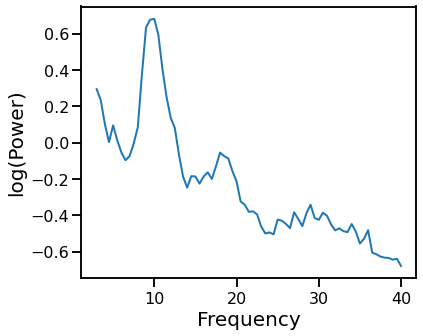

In [4]:
# Check a plot of the loaded power spectrum
plot_psds(freqs, psd)

## Check FOOOF Fit of Data

                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                        The model was run on the frequency range 3 - 40 Hz                        
                                 Frequency Resolution is 0.50 Hz                                  
                                                                                                  
                            Aperiodic Parameters (offset, exponent):                              
                                          0.5498, 0.6997                                          
                                                                                                  
                                       2 peaks were found:                                        
          

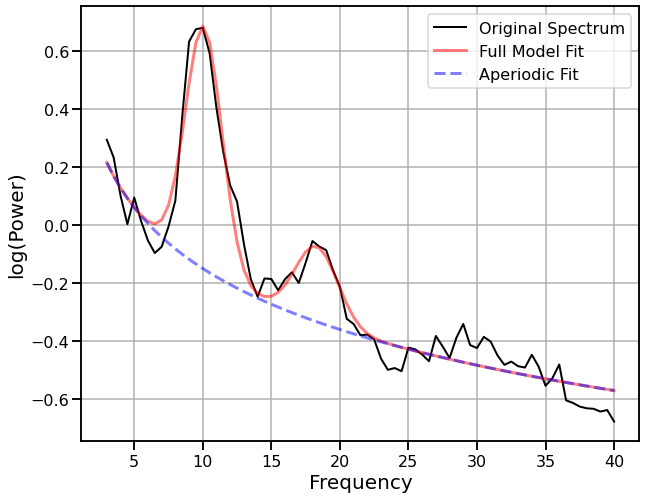

In [5]:
# Initialize FOOOF model
fm = FOOOF(peak_width_limits=[1, 8])

# Fit FOOOF model
fm.report(freqs, psd, [3, 40])
res_fooof = -fm.aperiodic_params_[1]

# Methods for Fitting Power Spectra

In this section, we demonstrate a series of methods for fitting models to power spectra, including:
- Linear fits to power spectra in log-log spacing
- Robust linear fitting to power spectra in log-log spacing
- RANSAC linear fitting to power spectra in log-log spacing
- Exponential fits to power spectra in semi-log spacing

All of the above are done in the following versions:
- Across the entire spectrum
- Using a predefined exclusion zone of the alpha oscillation (7-14 Hz)
- Using exclusing zones for all oscillatory peaks

We also compare these approaches to a parameterizing neural power spectra (FOOOF). 

## Linear Fits (in log-log)

In [6]:
# Add constant for fitting with statsmodels
fx = sm.add_constant(np.log10(freqs))

### OLS Linear Fit

Fit a line in log-log with Ordinary Least Squares (OLS).

In [7]:
# Spectral fit: linear fit
fit_ols = sm.OLS(np.log10(psd), fx).fit()
res_ols = fit_ols.params[1]

# Get the predicted values of the aperiodic fit
pred_vals = np.power(10, fit_ols.fittedvalues)

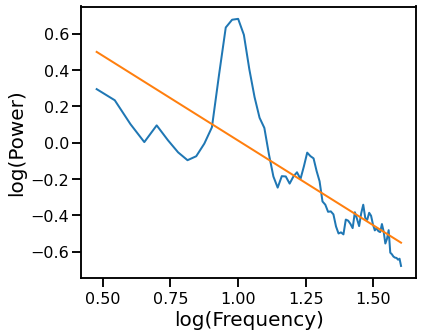

In [8]:
# Plot the aperiodic fit, from the OLS linear fit
plot_psds(freqs, [psd, pred_vals], log_freqs=True)

### Robust Fit with RLM

In [9]:
# Spectral fit: robust linear fit to log-log PSD
fit_rlm = sm.RLM(np.log10(psd), fx).fit()
res_rlm = fit_rlm.params[1]

# Get the predicted values of the aperiodic fit
pred_vals = np.power(10, fit_rlm.fittedvalues)

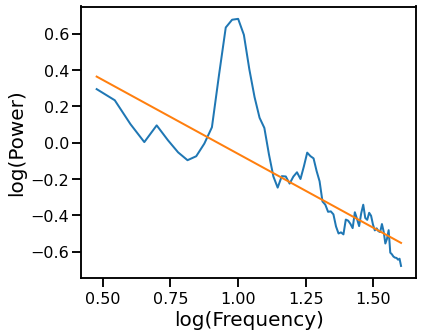

In [10]:
# Plot the aperiodic fit, from the robust linear fit
plot_psds(freqs, [psd, pred_vals], log_freqs=True)

### Robust Fit with RANSAC

In [11]:
# Reshape freqs for RANSAC fit
freqs = freqs.reshape([len(freqs), 1])

In [12]:
# Initialize and fit with RANSAC
ransac_model = RANSACRegressor()
ransac_model.fit(np.log10(freqs), np.log10(psd))
res_ran = ransac_model.estimator_.coef_[0]

# Get the predicted values of the aperiodic fit
pred_vals = np.power(10, ransac_model.predict(np.log10(freqs)))

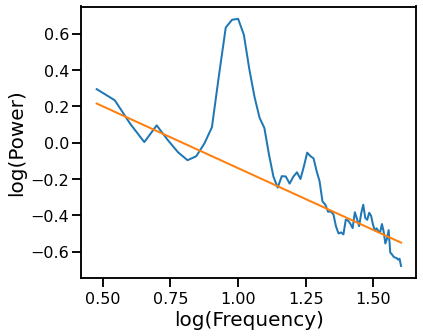

In [13]:
# Plot the aperiodic fit, from RANSAC
plot_psds(freqs.flatten(), [psd, pred_vals], log_freqs=True)

## Spectral Fitting Excluding Alpha

Use a specific exclusion zone for the alpha oscillation.

In [14]:
# Exclude predefined alpha range
freqs_alph, psd_alph = exclude_spectrum(np.squeeze(freqs), psd, [7, 14])#, False)

# Reset freqs, with constant
fx_alph = sm.add_constant(np.log10(freqs_alph))

### Simple OLS Linear Fit Exlucing Generic Alpha Band

In [15]:
# Linear fit without alpha range
fit_ols_alph = sm.OLS(np.log10(psd_alph), fx_alph).fit()
res_ols_alph = fit_ols_alph.params[1]

# Get the predicted values of the aperiodic fit
pred_vals = np.power(10, fit_ols_alph.fittedvalues)

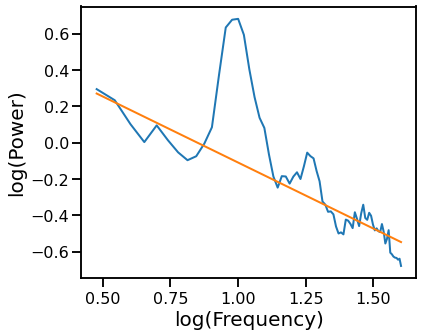

In [16]:
# Plot the aperiodic fit, from an OLS linear fit with an alpha exclusion zone
plot_psds([freqs, freqs_alph], [psd, pred_vals], log_freqs=True)

### Robust Fit with RLM Excluding Generic Alpha Band

In [17]:
# Robust fit without alpha range
fit_rlm_alph = sm.RLM(np.log10(psd_alph), fx_alph).fit()
res_rlm_alph = fit_rlm_alph.params[1]

# Get the predicted values of the aperiodic fit
pred_vals = np.power(10, fit_rlm_alph.fittedvalues)

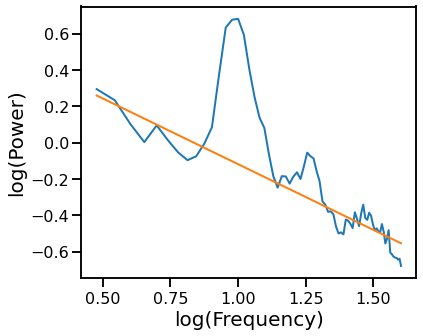

In [18]:
# Plot the aperiodic fit, from the robust linear fit with an alpha exclusion zone
plot_psds([freqs, freqs_alph], [psd, pred_vals], log_freqs=True)

### Robust Fit with RANSAC Excluding Generic Alpha Band

In [19]:
# Fit alpha-exclusion with RANSAC
ransac_model_alph = RANSACRegressor()
ransac_model_alph.fit(np.log10(freqs_alph), np.log10(psd_alph))
res_ran_alph = ransac_model_alph.estimator_.coef_[0][0]

# Get the predicted values of the aperiodic fit
pred_vals = np.power(10, ransac_model_alph.predict(np.log10(freqs_alph)))

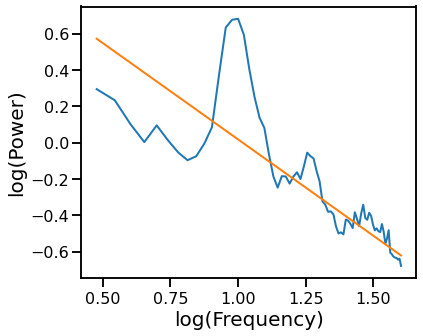

In [20]:
# Plot the aperiodic fit, from the RANSAC fit with alpha exclusion zone
plot_psds([freqs, freqs_alph], [psd, pred_vals], log_freqs=True)

## Spectral Fit Excluding Oscillations

Use a exclusion zones for oscillations.

In [21]:
# Get oscillation definitions from FOOOF
cens = fm.gaussian_params_[:, 0]
bws = fm.gaussian_params_[:, 2]

# Define oscillation ranges, as a range around each center frequency
m = 2
osc_ranges = [[cen-m*bw, cen+m*bw] for cen, bw in zip(cens, bws)]

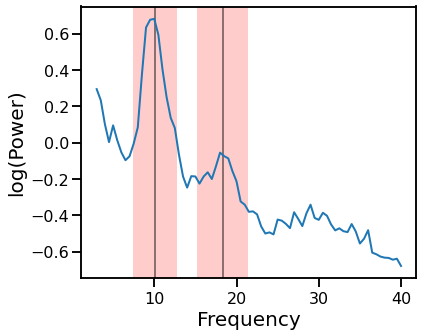

In [22]:
# Plot PSD with oscillatory regions shaded
plot_psds_shades(freqs, psd, osc_ranges)

In [23]:
# Exclude oscillation bands, as measured from FOOOF
psd_excl = psd
freqs_excl = np.squeeze(freqs)

for cen, bw in zip(cens, bws):
    freqs_excl, psd_excl = exclude_spectrum(freqs_excl, psd_excl, [cen-m*bw, cen+m*bw])

In [24]:
# Create a frequency vector with exlcusion zones for model fitting
fx_excl = sm.add_constant(np.log10(freqs_excl))

### Simple Linear Fit Excluding Oscillatory Bands

In [25]:
# Linear fit without alpha range
fit_ols_excl = sm.OLS(np.log10(psd_excl), fx_excl).fit()
res_ols_excl = fit_ols_excl.params[1]

# Get the predicted values of the aperiodic fit
pred_vals = np.power(10, fit_ols_excl.fittedvalues)

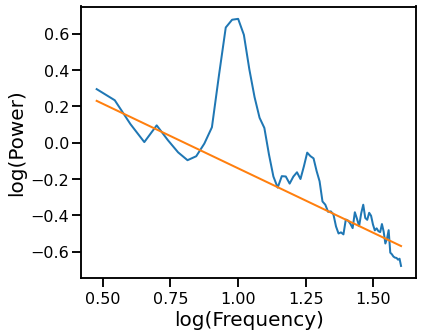

In [26]:
# Plot the aperiodic fit, from the OLS linear fit with oscillation exclusion zones
plot_psds([freqs, freqs_excl], [psd, pred_vals], log_freqs=True)

### Robust Fit with RLM Excluding Oscillatory Bands

In [27]:
# Robust fit without oscillation bands
fit_rlm_excl = sm.RLM(np.log10(psd_excl), fx_excl).fit()
res_rlm_excl = fit_rlm_excl.params[1]

# Get the predicted values of the aperiodic fit
pred_vals = np.power(10, fit_rlm_excl.fittedvalues)

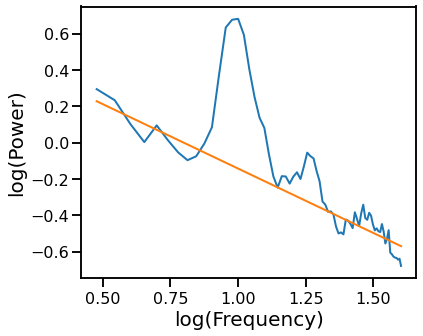

In [28]:
# Plot the aperiodic fit, from the robust linear fit with oscillation exclusion zones
plot_psds([freqs, freqs_excl], [psd, pred_vals], log_freqs=True)

### Robust Fit with RANSAC Excluding Oscillatory Bands

In [29]:
# Fit alpha-exclusion with RANSAC
ransac_model_excl = RANSACRegressor()
ransac_model_excl.fit(np.log10(freqs_excl), np.log10(psd_excl))
res_ran_excl = ransac_model_excl.estimator_.coef_[0][0]

# Get the predicted values of the aperiodic fit
pred_vals = np.power(10, ransac_model_excl.predict(np.log10(freqs_excl)))

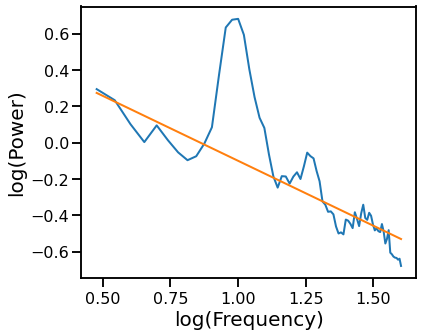

In [30]:
# Plot the aperiodic fit, from the RANSAC fit with oscillation exclusion zones
plot_psds([freqs, freqs_excl], [psd, pred_vals], log_freqs=True)

## Exponential Fits

### Exponential Fit

In [31]:
# Fit exponential 1/f, with scipy curve_fit
fit_exp, _ = curve_fit(expf, np.squeeze(freqs), np.squeeze(np.log10(psd)), p0=[1, 1])
res_exp = -fit_exp[1]

# Get the predicted values of the aperiodic fit
pred_vals = np.power(10, expf(freqs, *fit_exp))

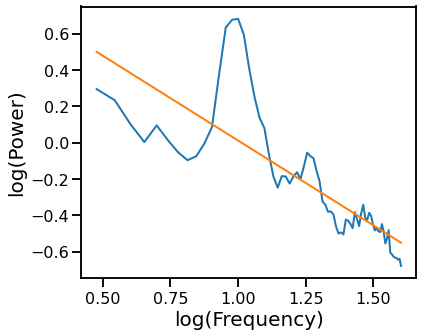

In [32]:
# Plot the aperiodic fit, from the exponential fit
plot_psds(freqs.flatten(), [psd, pred_vals], log_freqs=True)

### Exponential Fit Excluding Alpha Region

In [33]:
# Fit exponential 1/f, with scipy curve_fit, excluding alpha range
fit_exp_alph, _ = curve_fit(expf, np.squeeze(freqs_alph), np.squeeze(np.log10(psd_alph)), p0=[1, 1])
res_exp_alph = -fit_exp_alph[1]

# Get the predicted values of the aperiodic fit
pred_vals = np.power(10, expf(freqs_alph, *fit_exp_alph))

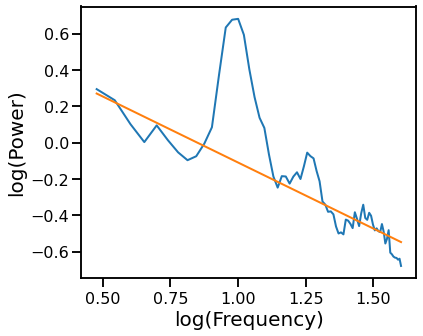

In [34]:
# Plot the aperiodic fit, from the exponential fit, with an alpha exclusion zone
plot_psds([freqs, freqs_alph], [psd, pred_vals], log_freqs=True)

### Exponential Fit Excluding Oscillation Regions

In [35]:
# Fit exponential 1/f, with scipy curve_fit, excluding oscillatory regions
fit_exp_excl, _ = curve_fit(expf, np.squeeze(freqs_excl), np.squeeze(np.log10(psd_excl)), p0=[1, 1])
res_exp_excl = -fit_exp_excl[1]

# Get the predicted values of the aperiodic fit
pred_vals = np.power(10, expf(freqs_excl, *fit_exp_excl))

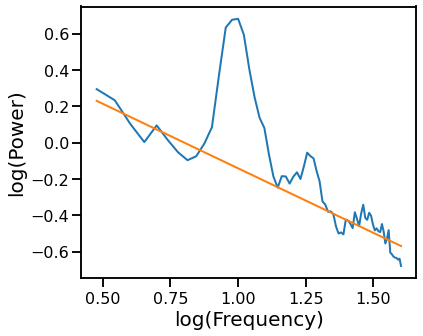

In [36]:
# Plot the aperiodic fit, from the exponential fit with oscillation exclusion zones
plot_psds([freqs, freqs_excl], [psd, pred_vals], log_freqs=True)

# Compare Fits


In [37]:
# Print out results across all the different approaches
print('FIT RESULTS \n')
print('OLS: \t\t\t', res_ols)
print('OLS-Exclude Alpha: \t', res_ols_alph)
print('OLS-Exclude Oscs: \t', res_ols_alph)
print('RLM: \t\t\t', res_rlm)
print('RLM-Exclude Alpha:\t', res_rlm_alph)
print('RLM-Exclude Oscs:\t', res_rlm_excl)
print('RANSAC:\t\t\t', res_ran)
print('RANSAC-Exclude Alpha:\t', res_ran_alph)
print('RANSAC-Exclude Oscs:\t', res_ran_excl)
print('EXP: \t\t\t', res_exp)
print('EXP-Exclude Alpha:\t', res_exp_alph)
print('EXP-Exclude Oscs:\t', res_exp_excl)
print('FOOOF:\t\t\t', res_fooof)

FIT RESULTS 

OLS: 			 -0.9330609197162156
OLS-Exclude Alpha: 	 -0.7264636292612343
OLS-Exclude Oscs: 	 -0.7264636292612343
RLM: 			 -0.8133822436432796
RLM-Exclude Alpha:	 -0.7228972564703875
RLM-Exclude Oscs:	 -0.7087758096893271
RANSAC:			 -0.680234333764502
RANSAC-Exclude Alpha:	 -1.0600427539860382
RANSAC-Exclude Oscs:	 -0.7145316009042937
EXP: 			 -0.9330609177414123
EXP-Exclude Alpha:	 -0.7264636300928028
EXP-Exclude Oscs:	 -0.7099949816130785
FOOOF:			 -0.6997273708605425


In [38]:
# Order fits by magnitude
all_res_fits = [(res_ols, 'OLS'), (res_ols_alph, 'OLS-EA'), (res_ols_excl, 'OLS-EO'),
                (res_rlm, 'RLM'), (res_rlm_alph, 'RLM-EA'), (res_rlm_excl, 'RLM-EO'),
                (res_ran, 'RAN'), (res_ran_alph, 'RAN-EA'), (res_ran_excl, 'RAN-EO'),
                (res_exp, 'EXP'), (res_exp_alph, 'EXP-EA'), (res_exp_excl, 'EXP-EO'),
                (res_fooof, 'FOOOF')]

all_res_fits.sort()
all_res_fits.reverse()

# Print out in order of fit magnitude
print('FIT RESULTS (SORTED):')
for fit in all_res_fits:
    print('\t {:1.5f} \t {}'.format(*fit))

FIT RESULTS (SORTED):
	 -0.68023 	 RAN
	 -0.69973 	 FOOOF
	 -0.70878 	 RLM-EO
	 -0.70999 	 OLS-EO
	 -0.70999 	 EXP-EO
	 -0.71453 	 RAN-EO
	 -0.72290 	 RLM-EA
	 -0.72646 	 OLS-EA
	 -0.72646 	 EXP-EA
	 -0.81338 	 RLM
	 -0.93306 	 EXP
	 -0.93306 	 OLS
	 -1.06004 	 RAN-EA
